# TP 2: Transfer learning with PyTorch

## Objective of the following tutorial: Reuse the CNN learnt previously on CIFAR-10 and finetune on CIFAR-100

## Load the useful packages

In [ ]:
import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import seaborn # advanced data plotting
from sklearn import preprocessing # basic ML models
# import scipy # scientific computing library

import os

import torch

Set the device

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" #0 indicates the GPU you gonna use
print(f"Using {device} device")

#### Reproducibility

In [ ]:
# Set the random seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Load and preprocess the data

The data can be directly downloaded with PyTorch. Please visit the following website: https://pytorch.org/vision/stable/datasets.html.
The dataset must have the same number of channels as the original dataset used for the pretrained model.

In [ ]:
import torchvision
import torchvision.transforms as transforms

#### **CIFAR10 stats**
mean: ([0.4914, 0.4822, 0.4465])

std: ([0.2470, 0.2435, 0.2616])

#### **CIFAR100 stats**
mean: ([0.5071, 0.4865, 0.4409])

std: ([0.2673, 0.2564, 0.2762])

How to retrieve those means and standard deviations:

In [ ]:
train_data = torchvision.datasets.CIFAR100('./', train=True, download=True)

# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()

In [ ]:
mean , std

In [ ]:
# TODO

transform = ...

dataset = ...

testset = ...

#### Train-test split

In [ ]:
from sklearn.model_selection import train_test_split
# TODO
train_indices, val_indices = ...

#### Dataloaders

In [ ]:
trainloader = ...
valloader = ...
testloader = ...

## Transfer learning

### Load and fine tune the pretrained model

Configurate the model first

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module): # must correspond to the pretrained model set
    def __init__(self):
      super().__init__() # always subclass
      # to fill

    def forward(self, x):
      # to fill

If you do not have your pretrained model and you use the pretrained CNN provided by the teacher, uncomment the following cell and use this as your model architecture.

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F

# class CNN(nn.Module):
#     def __init__(self):
#         super().__init__() # always subclass
#         self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same") # first conv layer
#         self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,padding="same") # second conv layer
#         self.pool1 = nn.MaxPool2d(kernel_size=2) # maxpooling
#         self.dp1 = nn.Dropout(p=0.2)
#         self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same") # first conv layer
#         self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,padding="same") # second conv layer
#         self.pool2 = nn.MaxPool2d(kernel_size=2) # maxpooling
#         self.dp2 = nn.Dropout(p=0.3)
#         self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same") # first conv layer
#         self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,padding="same") # second conv layer
#         self.pool3 = nn.MaxPool2d(kernel_size=2) # maxpooling
#         self.dp3 = nn.Dropout(p=0.6)

#         self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=512) # linear layer after flattening
#         self.dp4 = nn.Dropout(p=0.5)
#         self.fc2 = nn.Linear(in_features=512, out_features=10) # we have 10 probability classes to predict so 10 output features

#     def forward(self, x):
#       x = self.conv1_1(x)
#       x = F.relu(x)
#       x = self.conv1_2(x)
#       x = F.relu(x)
#       x = self.pool1(x)
#       x = self.dp1(x)

#       x = self.conv2_1(x)
#       x = F.relu(x)
#       x = self.conv2_2(x)
#       x = F.relu(x)
#       x = self.pool2(x)
#       x = self.dp2(x)

#       x = self.conv3_1(x)
#       x = F.relu(x)
#       x = self.conv3_2(x)
#       x = F.relu(x)
#       x = self.pool3(x)
#       x = self.dp3(x)

#       x = torch.flatten(x, 1)
#       x = self.fc1(x)
#       x = F.relu(x)
#       x = self.dp4(x)
#       x = self.fc2(x)
#       return x

Load the previous model:

- On the left toolbar, click on the `Folders` icon
- Click on the import button
- Select the model weights to load as a `.pkt` file
- Instantiate the correct model path below

In [ ]:
PATH = './cifar10_net.pth' # path to pretrained weights
model = CNN() # instantiate model
model.load_state_dict(torch.load(PATH)) # load pretrained weights

In [ ]:
# Check weights names
params = model.state_dict()
params.keys()

Freeze the parameters for the convolution part (before flatten)  <br>
Help: https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In [ ]:
for name, param in model.named_parameters():
  if param.requires_grad and 'conv' in name:
    param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():print(name, param.requires_grad)

Update the out_dim of the last FC layer and change the output size (from 10 to 100).

In [ ]:
num_ftrs = model.fc2.in_features # retrieve input features
model.fc2 = nn.Linear(num_ftrs, ...) # TODO: change output size
model= model.to(device) # to device

In [ ]:
# Compared to keras, we need to instantiate our performance metric
def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true,y_pred))) / y_true.shape[0]

Finetune the model

In [ ]:
# training function

from tqdm import tqdm
import torch.optim as optim


def train_model(model, epochs, train_loader, val_loader, learning_rate=1e-3, device=None):
  # Init
  output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities
  criterion = nn.CrossEntropyLoss() # we instantiate the loss function
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate) # filter only trainable parameters

  # TODO
  ...

  return loss_train, acc_train, loss_valid, acc_valid

In [ ]:
loss_train, acc_train, loss_valid, acc_valid = train_model(model, 15, trainloader, valloader, device=device)

In [ ]:
plt.plot(acc_train, label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(acc_valid, label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model finetuned accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

In [ ]:
plt.plot(loss_train, label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(loss_valid, label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model finetuned loss")
plt.xlabel('#Epochs')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))

In [ ]:
output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities

model.eval()
with torch.no_grad():
  idx = 0
  for batch in testloader:
    inputs,labels=batch
    inputs=inputs.to(device)
    labels=labels.to(device)
    if idx==0:
      t_out = model(x=inputs)
      t_out = output_fn(t_out).detach().cpu().numpy()
      t_out=t_out.argmax(axis=1)
      ground_truth = labels.detach().cpu().numpy()
    else:
      out = model(x=inputs)
      t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
      ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
    idx+=1

print("Test accuracy {}".format(get_accuracy(ground_truth,t_out)))

## Learn the model from scratch

Do not load the previous model, the parameters will be randomly initialized.

In [ ]:
class CNN_cifar100(nn.Module):
    def __init__(self):
      # TODO

    def forward(self, x):
      # TODO

In [ ]:
model_cifar100 = CNN_cifar100() # instantiate model
model_cifar100= model_cifar100.to(device)

In [ ]:
loss_train, acc_train, loss_valid, acc_valid = train_model(model_cifar100, 30, trainloader, valloader, device=device)

In [ ]:
plt.plot(acc_train, label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(acc_valid, label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model from scratch accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

In [ ]:
plt.plot(loss_train, label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(loss_valid, label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model from scratch loss")
plt.xlabel('#Epochs')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))

In [ ]:
output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities

model_cifar100.eval()
with torch.no_grad():
  idx = 0
  for batch in testloader:
    inputs,labels=batch
    inputs=inputs.to(device)
    labels=labels.to(device)
    if idx==0:
      t_out = model_cifar100(x=inputs)
      t_out = output_fn(t_out).detach().cpu().numpy()
      t_out=t_out.argmax(axis=1)
      ground_truth = labels.detach().cpu().numpy()
    else:
      out = model_cifar100(x=inputs)
      t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
      ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
    idx+=1

print("Test accuracy {}".format(get_accuracy(ground_truth,t_out)))

## Use a pretrained model from torch.models

## Use a pretrained model from torch.models

Help:

- https://pytorch.org/vision/stable/models.html,
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce <br>
- https://medium.com/@kirudang/deep-learning-computer-vision-using-transfer-learning-resnet-18-in-pytorch-skin-cancer-8d5b158893c5

See the benchmark on image classification:
- https://keras.io/api/applications/
- https://paperswithcode.com/sota/image-classification-on-imagenet
- https://paperswithcode.com/sota/image-classification-on-cifar-10
- https://paperswithcode.com/sota/image-classification-on-cifar-100

Documentation: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#resnet18

####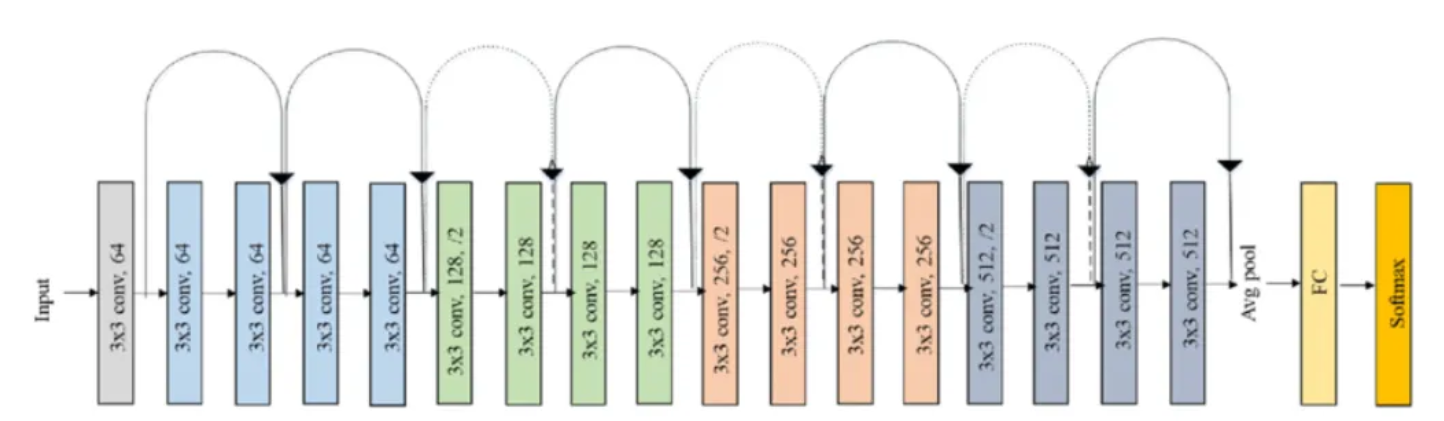 Resnet 18


In [ ]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True)

In [ ]:
# freeze model weights

# TODO


In [ ]:
# update the final layer

# TODO

In [ ]:
# to device
# TODO

#### Finetune the Resnet model

In [ ]:
loss_train, acc_train, loss_valid, acc_valid = train_model(resnet, 15, trainloader, valloader, device=device)

In [ ]:
plt.plot(acc_train, label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(acc_valid, label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("Resnet18 model finetuned - accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

In [ ]:
plt.plot(loss_train, label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(loss_valid, label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("Resnet18 model finetuned - loss")
plt.xlabel('#Epochs')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))

In [ ]:
output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities

resnet.eval()
with torch.no_grad():
  idx = 0
  for batch in testloader:
    inputs,labels=batch
    inputs=inputs.to(device)
    labels=labels.to(device)
    if idx==0:
      t_out = resnet(x=inputs)
      t_out = output_fn(t_out).detach().cpu().numpy()
      t_out=t_out.argmax(axis=1)
      ground_truth = labels.detach().cpu().numpy()
    else:
      out = resnet(x=inputs)
      t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
      ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
    idx+=1

print("Test accuracy {}".format(get_accuracy(ground_truth,t_out)))

## Go further :

- Use few samples from classes of the target data no included in the source data to evaluate the advantages of transfer learning
- For fun, we can try to apply your pretrained model to [Plantnet dataset](https://plantnet.org/en/2021/03/30/a-plntnet-dataset-for-machine-learning-researchers/)
- [Neural style transfer](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)